<a href="https://colab.research.google.com/github/RuslanMavlitov/IDE/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22SF_mod_3_cifar10_m3_v2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.9.2
2.9.0


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

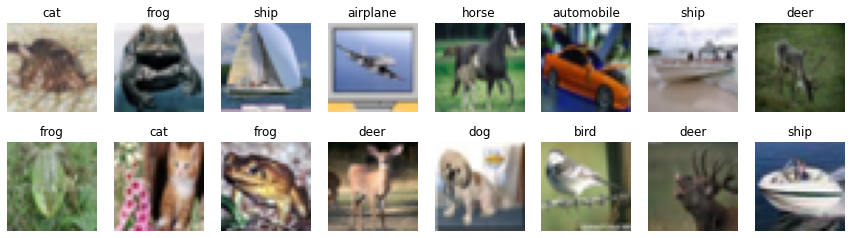

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [7]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [8]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [17]:
input_shape = (None, 32, 32, 3)

In [22]:
def make_default_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape[1:]))
    model.add(Dropout(.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Dropout(.25))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [23]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                        

# Тренируем модель

In [24]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [25]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5287 - accuracy: 0.4449 - val_loss: 1.2984 - val_accuracy: 0.5469
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1894 - accuracy: 0.5769 - val_loss: 1.0834 - val_accuracy: 0.6318
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0403 - accuracy: 0.6329 - val_loss: 0.9529 - val_accuracy: 0.6708
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9485 - accuracy: 0.6667 - val_loss: 0.9041 - val_accuracy: 0.6927
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8813 - accuracy: 0.6892 - val_loss: 0.8523 - val_accuracy: 0.7080
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8377 - accuracy: 0.7039 - val_loss: 0.8425 - val_accuracy: 0.7038
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7990 - accuracy: 0.7170 - val_loss: 0.7902 - val_accuracy:

На дефолтной архитектуре значения точности 74%.

In [26]:
def make_sigmoid_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='sigmoid', input_shape=input_shape[1:]))
    model.add(Dropout(.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    model.add(Dropout(.25))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [27]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3163 - accuracy: 0.0962 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3028 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3030 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3028 - accuracy: 0.0962 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3028 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3028 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3028 - accuracy: 0.0965 - val_loss: 2.3026 - val_accuracy

На функции активации сигмойда - модель не обучилась, сильный затухающий градиент, так как сигмойда ограничивает градиенты

In [28]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9871 - accuracy: 0.2744 - val_loss: 1.9010 - val_accuracy: 0.3783
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6708 - accuracy: 0.4002 - val_loss: 1.6640 - val_accuracy: 0.4641
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5207 - accuracy: 0.4554 - val_loss: 1.5469 - val_accuracy: 0.5062
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4213 - accuracy: 0.4907 - val_loss: 1.4343 - val_accuracy: 0.5411
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3485 - accuracy: 0.5171 - val_loss: 1.3593 - val_accuracy: 0.5559
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2929 - accuracy: 0.5380 - val_loss: 1.3188 - val_accuracy: 0.5667
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2413 - accuracy: 0.5550 - val_loss: 1.2574 - val_accuracy:

Сравнили Стахостический градиентный спуск с "Адамом", SGD оказался хуже

In [29]:
def make_bn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [30]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4775 - accuracy: 0.4828 - val_loss: 1.3376 - val_accuracy: 0.5516
Epoch 2/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.0396 - accuracy: 0.6348 - val_loss: 1.1616 - val_accuracy: 0.6206
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9126 - accuracy: 0.6810 - val_loss: 1.4541 - val_accuracy: 0.6202
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8383 - accuracy: 0.7085 - val_loss: 1.5870 - val_accuracy: 0.6272
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7741 - accuracy: 0.7293 - val_loss: 1.6254 - val_accuracy: 0.6541
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7200 - accuracy: 0.7508 - val_loss: 1.4582 - val_accuracy: 0.6793
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6861 - accuracy: 0.7608 - val_loss: 2.0136 - val_ac

Нормализация не помогла 

In [31]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='sigmoid', input_shape=input_shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [32]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.4610 - accuracy: 0.4878 - val_loss: 2.5035 - val_accuracy: 0.3326
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0772 - accuracy: 0.6201 - val_loss: 3.0864 - val_accuracy: 0.3201
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9744 - accuracy: 0.6583 - val_loss: 2.8177 - val_accuracy: 0.3942
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9070 - accuracy: 0.6851 - val_loss: 4.0321 - val_accuracy: 0.3605
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8637 - accuracy: 0.7007 - val_loss: 2.2824 - val_accuracy: 0.4473
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8256 - accuracy: 0.7128 - val_loss: 2.3125 - val_accuracy: 0.4471
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7965 - accuracy: 0.7235 - val_loss: 1.7777 - val_ac

А вот с активацией "сигмойда" сеть с нормализацией уже дает результаты и обучается